## scVI-tools based integration

In [1]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch

/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.0


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Load datasets

In [4]:
# file paths for query and reference
query_path = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/query_norm_v2.h5ad"
ref_path = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/ref_norm_v3.h5ad"

# load data
query_data = sc.read_h5ad(query_path)
ref_data = sc.read_h5ad(ref_path)

In [5]:
query_data

AnnData object with n_obs × n_vars = 50394 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'total_counts_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
 

In [6]:
ref_data

AnnData object with n_obs × n_vars = 37522 × 20500
    obs: 'sample_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex'
    var: 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_

In [7]:
# update the obs column name of ref_data from orig.ident to sample_id
ref_data.obs.rename(columns={"orig.ident": "sample_id"}, inplace=True)
# use the first letter of the sample_id to create a new column sex
ref_data.obs["sex"] = ref_data.obs["sample_id"].str[0]
# make the sex column a categorical variable
ref_data.obs["sex"] = ref_data.obs["sex"].astype("category")


#### Filter cells from reference using the same thresholds as query cells

In [8]:
# cell bender probability of being cell and not soup
ref_data = ref_data[ref_data.obs['cell_probability'] > 0.99]
# Basic filtering based on number of genes
sc.pp.filter_cells(ref_data, min_genes=200) 

/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [9]:
ref_data

AnnData object with n_obs × n_vars = 37522 × 20500
    obs: 'sample_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex'
    var: 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_

In [ ]:
#write ref_data to file
ref_data.write_h5ad("/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/ref_norm_v3.h5ad")


### Concat the datasets

In [10]:
# add batch obs to both datasets
ref_data.obs["batch"] = "2024"
query_data.obs["batch"] = "2025"

In [11]:
query_data.obs["cell_type"] = "Unknown"

In [12]:
ref_data.X = ref_data.layers["cellbender"]
query_data.X = query_data.layers["cellbender"]

In [13]:
# Find common genes
common_genes = ref_data.var_names.intersection(query_data.var_names)
print(f"Common genes: {len(common_genes)}")

Common genes: 20500


In [14]:
# Subset both datasets to common genes
ref_data = ref_data[:, common_genes].copy()
query_data = query_data[:, common_genes].copy()

In [15]:
adata = anndata.concat([ref_data, query_data])

/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
adata

AnnData object with n_obs × n_vars = 87916 × 20500
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch'
    obsm: 'gene_expression_encoding'
    layers: 'cellbender', 'counts'

In [17]:
# filter genes
# For mouse data (based on your gene names):
adata.var['hb'] = adata.var_names.str.contains('^Hb[^(p)]', case=False)
adata.var['ribo'] = adata.var_names.str.contains('^Rp[sl]', case=False)
adata.var['mt'] = adata.var_names.str.contains('^mt-', case=False)
print("\nHemoglobin genes found:")
print(adata.var[adata.var['hb']].index.tolist())
print("Mitochondrial genes found:")
print(adata.var[adata.var['mt']].index.tolist())
print("Ribosomal genes found:")
print(adata.var[adata.var['ribo']].index.tolist())


Hemoglobin genes found:
['Hbb-bt', 'Hbb-bs', 'Hbs1l', 'Hba-a1', 'Hba-a2', 'Hbegf']
Mitochondrial genes found:
['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Ribosomal genes found:
['Rpl7', 'Rpl31', 'Rpl37a', 'Rps6kc1', 'Rpl7a', 'Rpl12', 'Rpl35', 'Rps21', 'Rpl22l1', 'Rps3a1', 'Rps27', 'Rpl34', 'Rps20', 'Rps6', 'Rps8', 'Rps6ka1', 'Rpl11', 'Rpl22', 'Rpl9', 'Rpl5', 'Rplp0', 'Rpl6', 'Rpl21', 'Rpl32', 'Rps9', 'Rpl28', 'Rps5', 'Rps19', 'Rps16', 'Rps11', 'Rpl13a', 'Rpl18', 'Rps17', 'Rps3', 'Rpl27a', 'Rps13', 'Rps15a', 'Rplp2', 'Rpl18a', 'Rpl13', 'Rps25', 'Rpl10-ps3', 'Rplp1', 'Rpl4', 'Rps27l', 'Rpl29', 'Rps27rt', 'Rpsa', 'Rpl14', 'Rps12', 'Rps15', 'Rpl41', 'Rps26', 'Rps27a', 'Rpl26', 'Rpl23a', 'Rps6kb1', 'Rpl23', 'Rpl19', 'Rpl27', 'Rpl38', 'Rps7', 'Rps29', 'Rpl36al', 'Rps6kl1', 'Rps6ka5', 'Rps23', 'Rpl15', 'Rps24', 'Rpl36a-ps1', 'Rpl37', 'Rpl30', 'Rpl8', 'Rpl3', 'Rps19bp1', 'Rpl35a', 'Rpl24', 'Rps6ka2', 'R

In [18]:
# remove all genes that are encoded in mitochondrial DNA
adata = adata[:,(~adata.var['mt'] & ~adata.var['ribo']) & ~adata.var['hb']] # Filter mitochondrial, linc, ribosomal, haemoglobin genes

In [19]:
adata

View of AnnData object with n_obs × n_vars = 87916 × 20384
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch'
    var: 'hb', 'ribo', 'mt'
    obsm: 'gene_expression_encoding'
    layers: 'cellbender', 'counts'

In [20]:
adata.layers["cellbender"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=4000,
    layer="cellbender",
    batch_key="batch",
    subset=True
)

/tmp/ipykernel_60236/1644353772.py:1: ImplicitModificationWarning: Setting element `.layers['cellbender']` of view, initializing view as actual.
  adata.layers["cellbender"] = adata.X.copy()
/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Train scVI model on the concatenated dataset (cellbender counts)

In [21]:
scvi.model.SCVI.setup_anndata(adata, layer="cellbender", batch_key="batch")
model = scvi.model.SCVI(adata, n_layers=2, n_latent=32, n_hidden=128)
model.train()

/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ocean/projects/cis240075p/asachan/.conda/envs/scvi- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ocean/projects/cis240075p/asachan/.conda/envs/scvi- ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/lightning/p

Epoch 91/91: 100%|██████████| 91/91 [05:55<00:00,  3.85s/it, v_num=1, train_loss=704]

`Trainer.fit` stopped: `max_epochs=91` reached.


Epoch 91/91: 100%|██████████| 91/91 [05:55<00:00,  3.90s/it, v_num=1, train_loss=704]


In [22]:
### Save the model
model.save("/ocean/projects/cis240075p/asachan/datasets/TA_muscle/models/scvi_model_v1.pt")

In [23]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [24]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=1e4,
    return_numpy=True
)

In [25]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

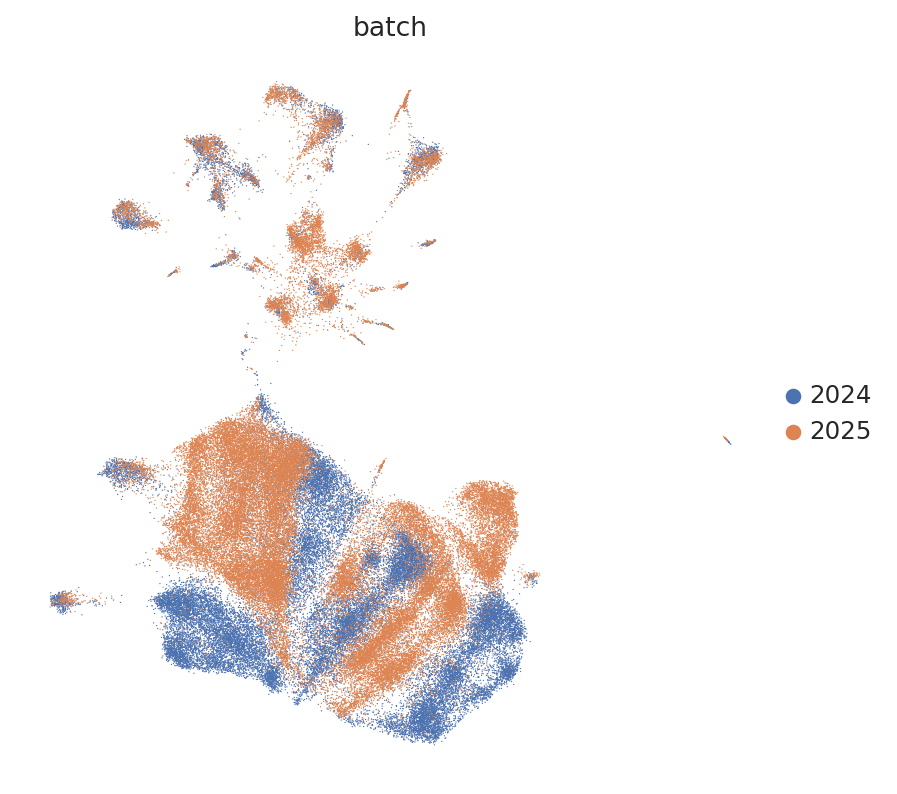

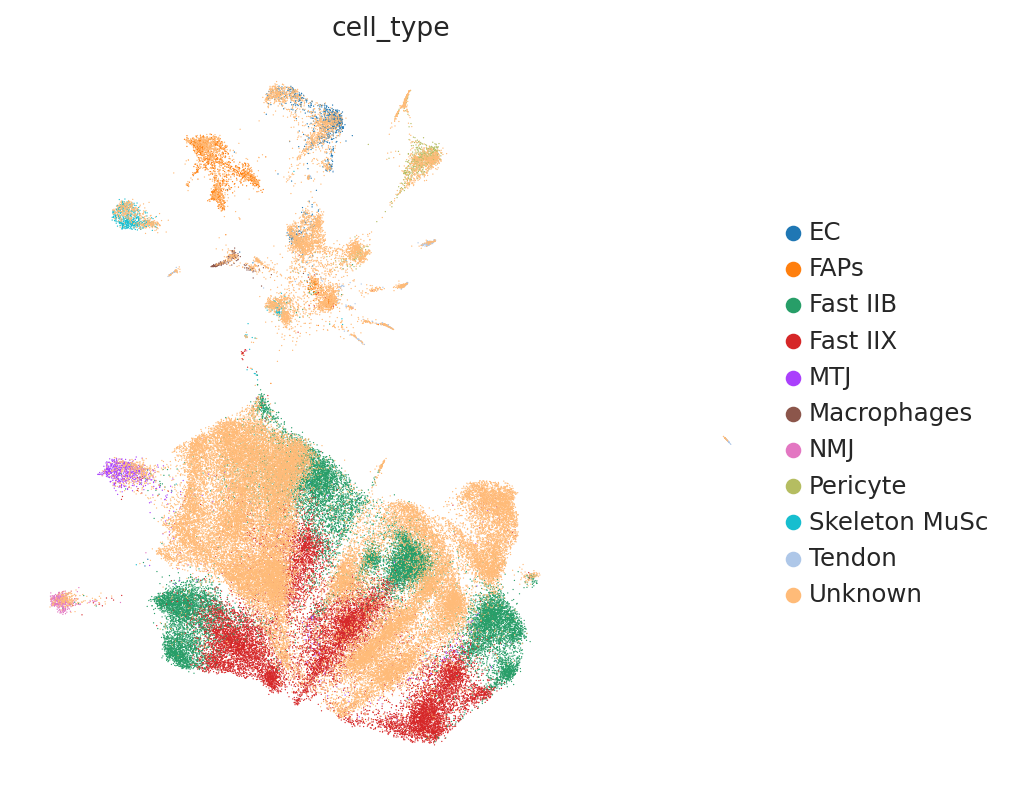

In [26]:
sc.pl.umap(
    adata,
    color=["batch"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

## scANVI for label transfer

In [27]:
SCANVI_CELLTYPE_KEY = "cell_type"
np.unique(adata.obs[SCANVI_CELLTYPE_KEY], return_counts=True)

(array(['EC', 'FAPs', 'Fast IIB', 'Fast IIX', 'MTJ', 'Macrophages', 'NMJ',
        'Pericyte', 'Skeleton MuSc', 'Tendon', 'Unknown'], dtype=object),
 array([  935,  1421, 16500, 15571,   843,   190,   364,   717,   674,
          307, 50394]))

In [28]:
# use pretrained scvi model to get the latent space
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key=SCANVI_CELLTYPE_KEY,
)

In [29]:
# train the model
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ocean/projects/cis240075p/asachan/.conda/envs/scvi- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ocean/projects/cis240075p/asachan/.conda/envs/scvi- ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/lightning/p

Epoch 20/20: 100%|██████████| 20/20 [02:44<00:00,  8.17s/it, v_num=1, train_loss=694]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:44<00:00,  8.22s/it, v_num=1, train_loss=694]


In [30]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

In [31]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

In [32]:
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
    adata.obs.C_scANVI.values, categories=adata.obs.cell_type.cat.categories
)

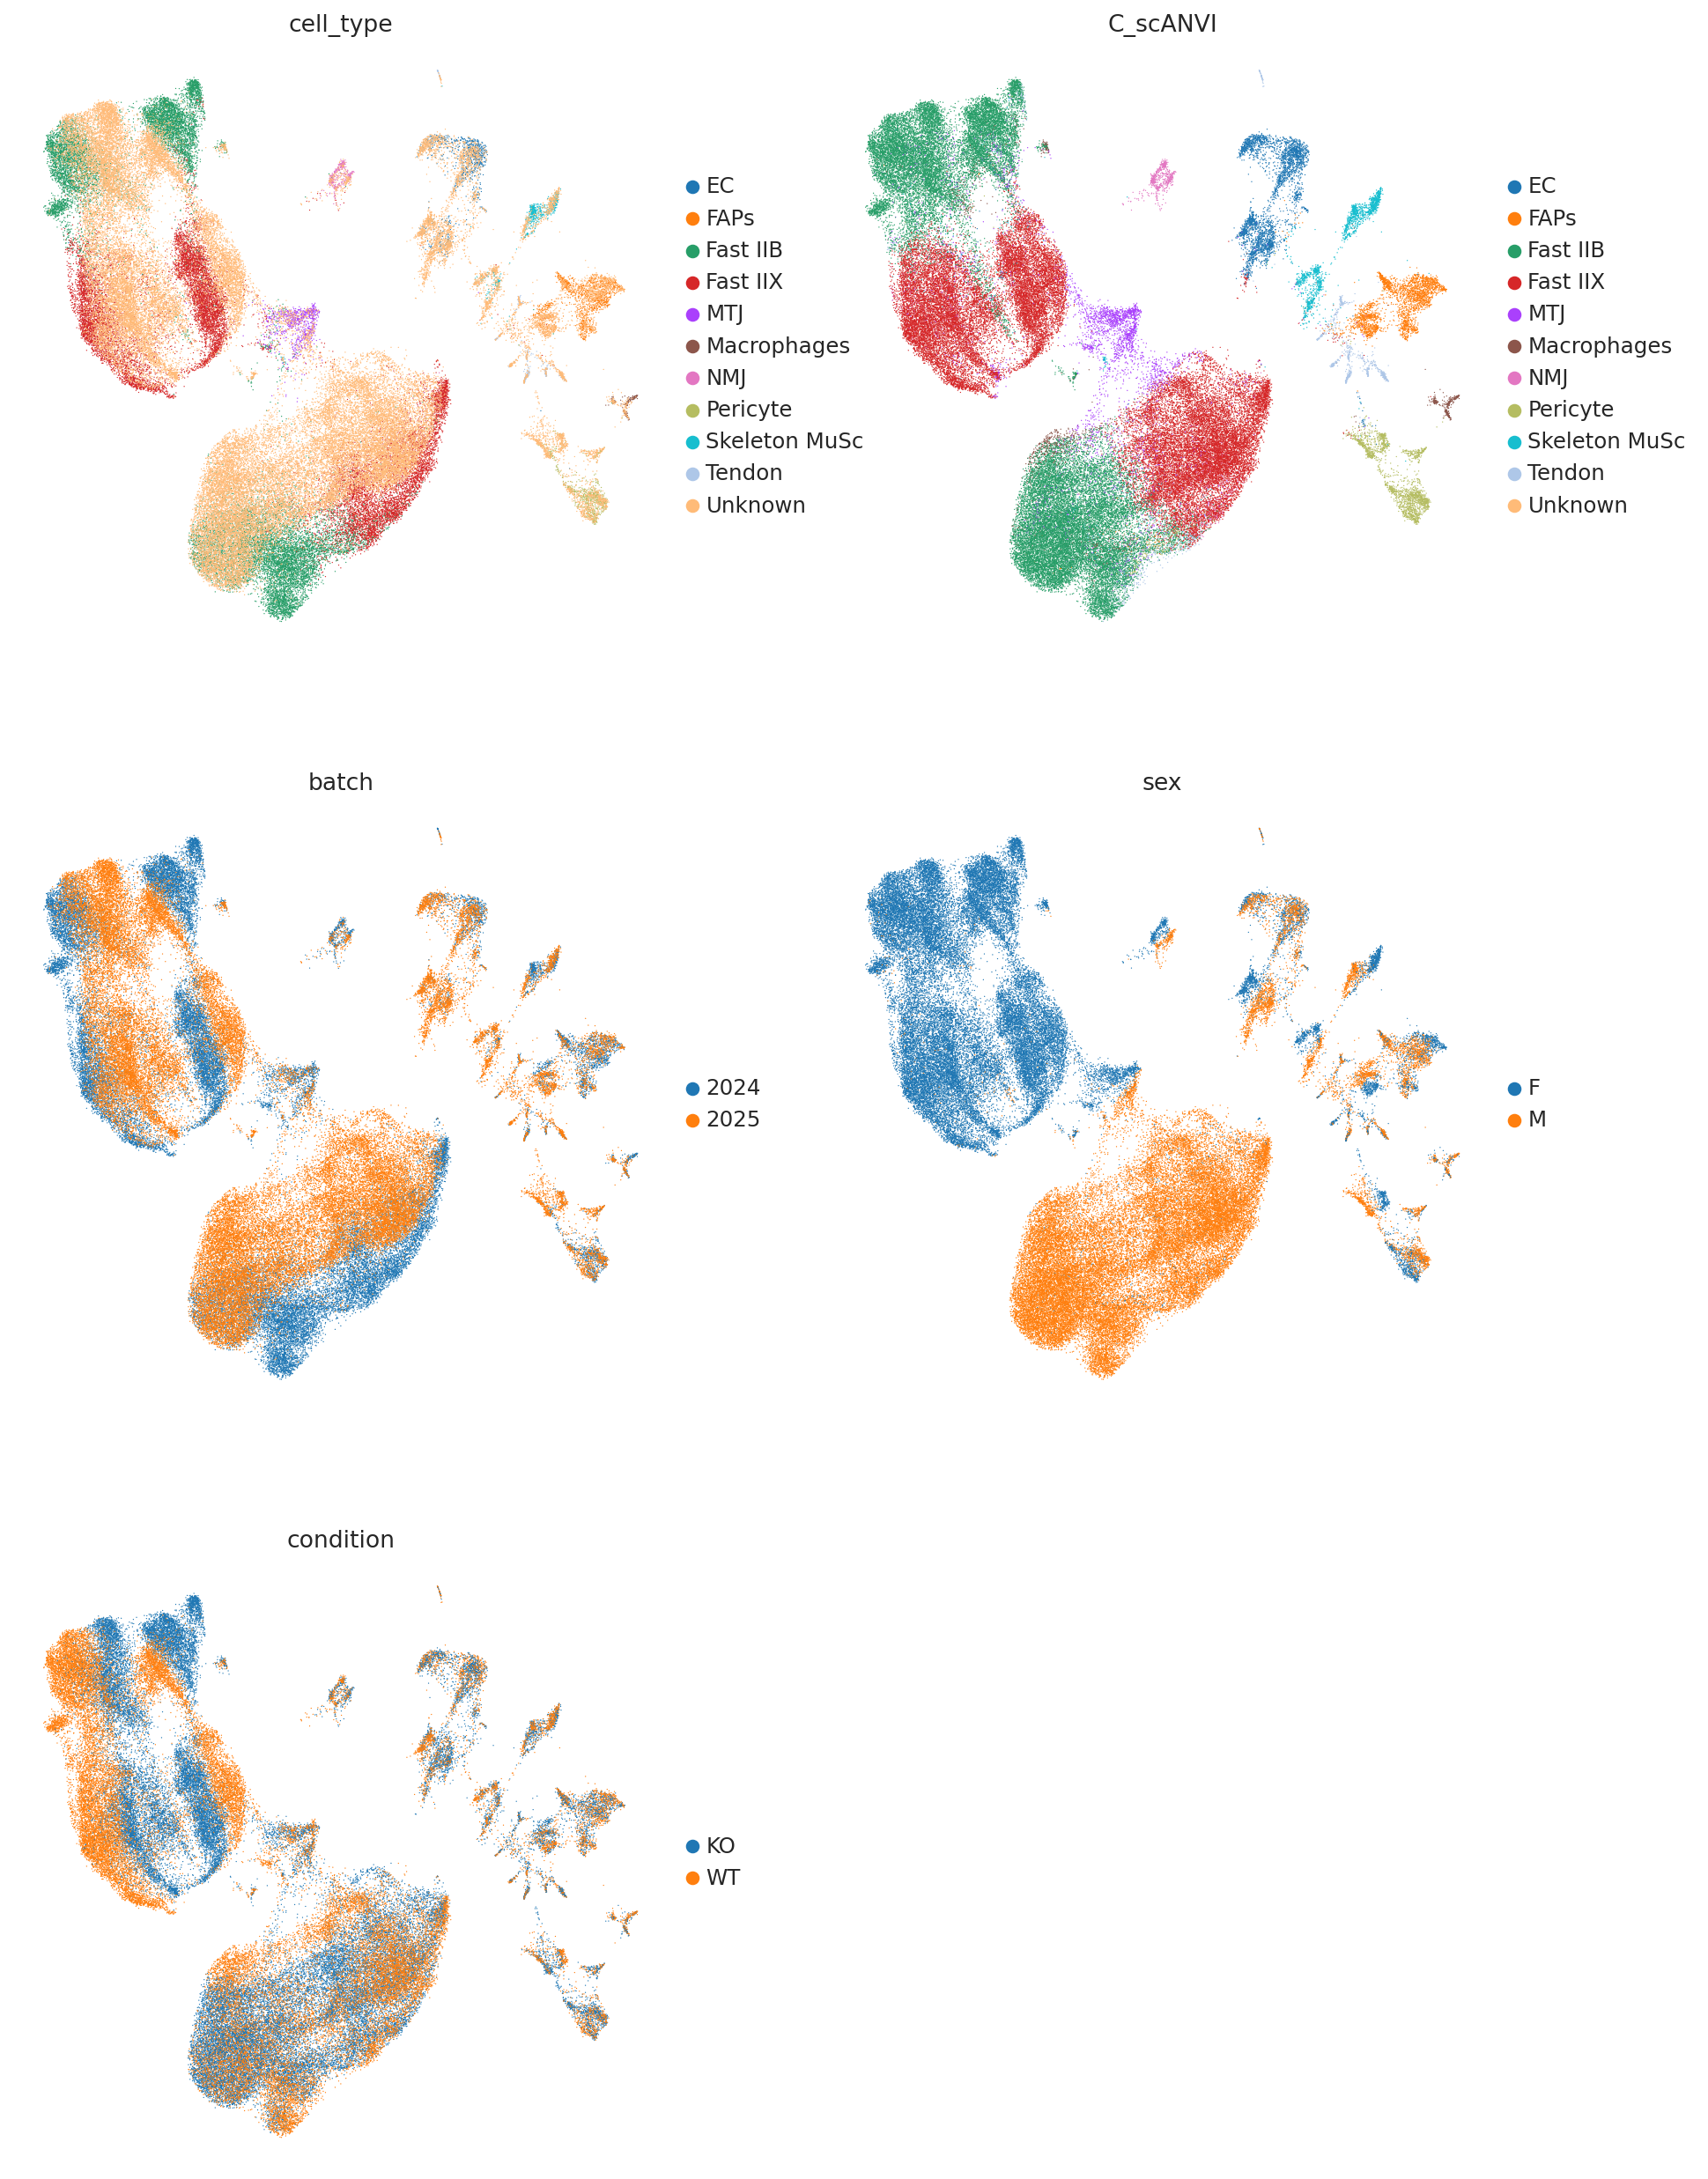

In [33]:
sc.pl.umap(
    adata,
    color=["cell_type", SCANVI_PREDICTION_KEY, "batch", "sex", "condition"],
    frameon=False,
    ncols=2,
    palette=adata.uns["cell_type_colors"],
)

In [34]:
# write the integrated adata to file
adata.write_h5ad("/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/scANVI_v2.h5ad")

## Check certain gene's exp
#### Atp2a1 should be high in KO samples

In [21]:
adata = sc.read_h5ad("/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/scANVI_v2.h5ad")

/ocean/projects/cis240075p/asachan/.conda/envs/scvi-env/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [22]:
#adata.obs["C_scANVI"] = adata.obs["C_scANVI"].cat.remove_unused_categories()
adata.obs["C_scANVI"].value_counts()

C_scANVI
Fast IIB         34755
Fast IIX         34393
MTJ               3718
EC                3561
FAPs              2735
Pericyte          2357
Skeleton MuSc     2004
Tendon            1486
Macrophages       1471
NMJ               1436
Name: count, dtype: int64

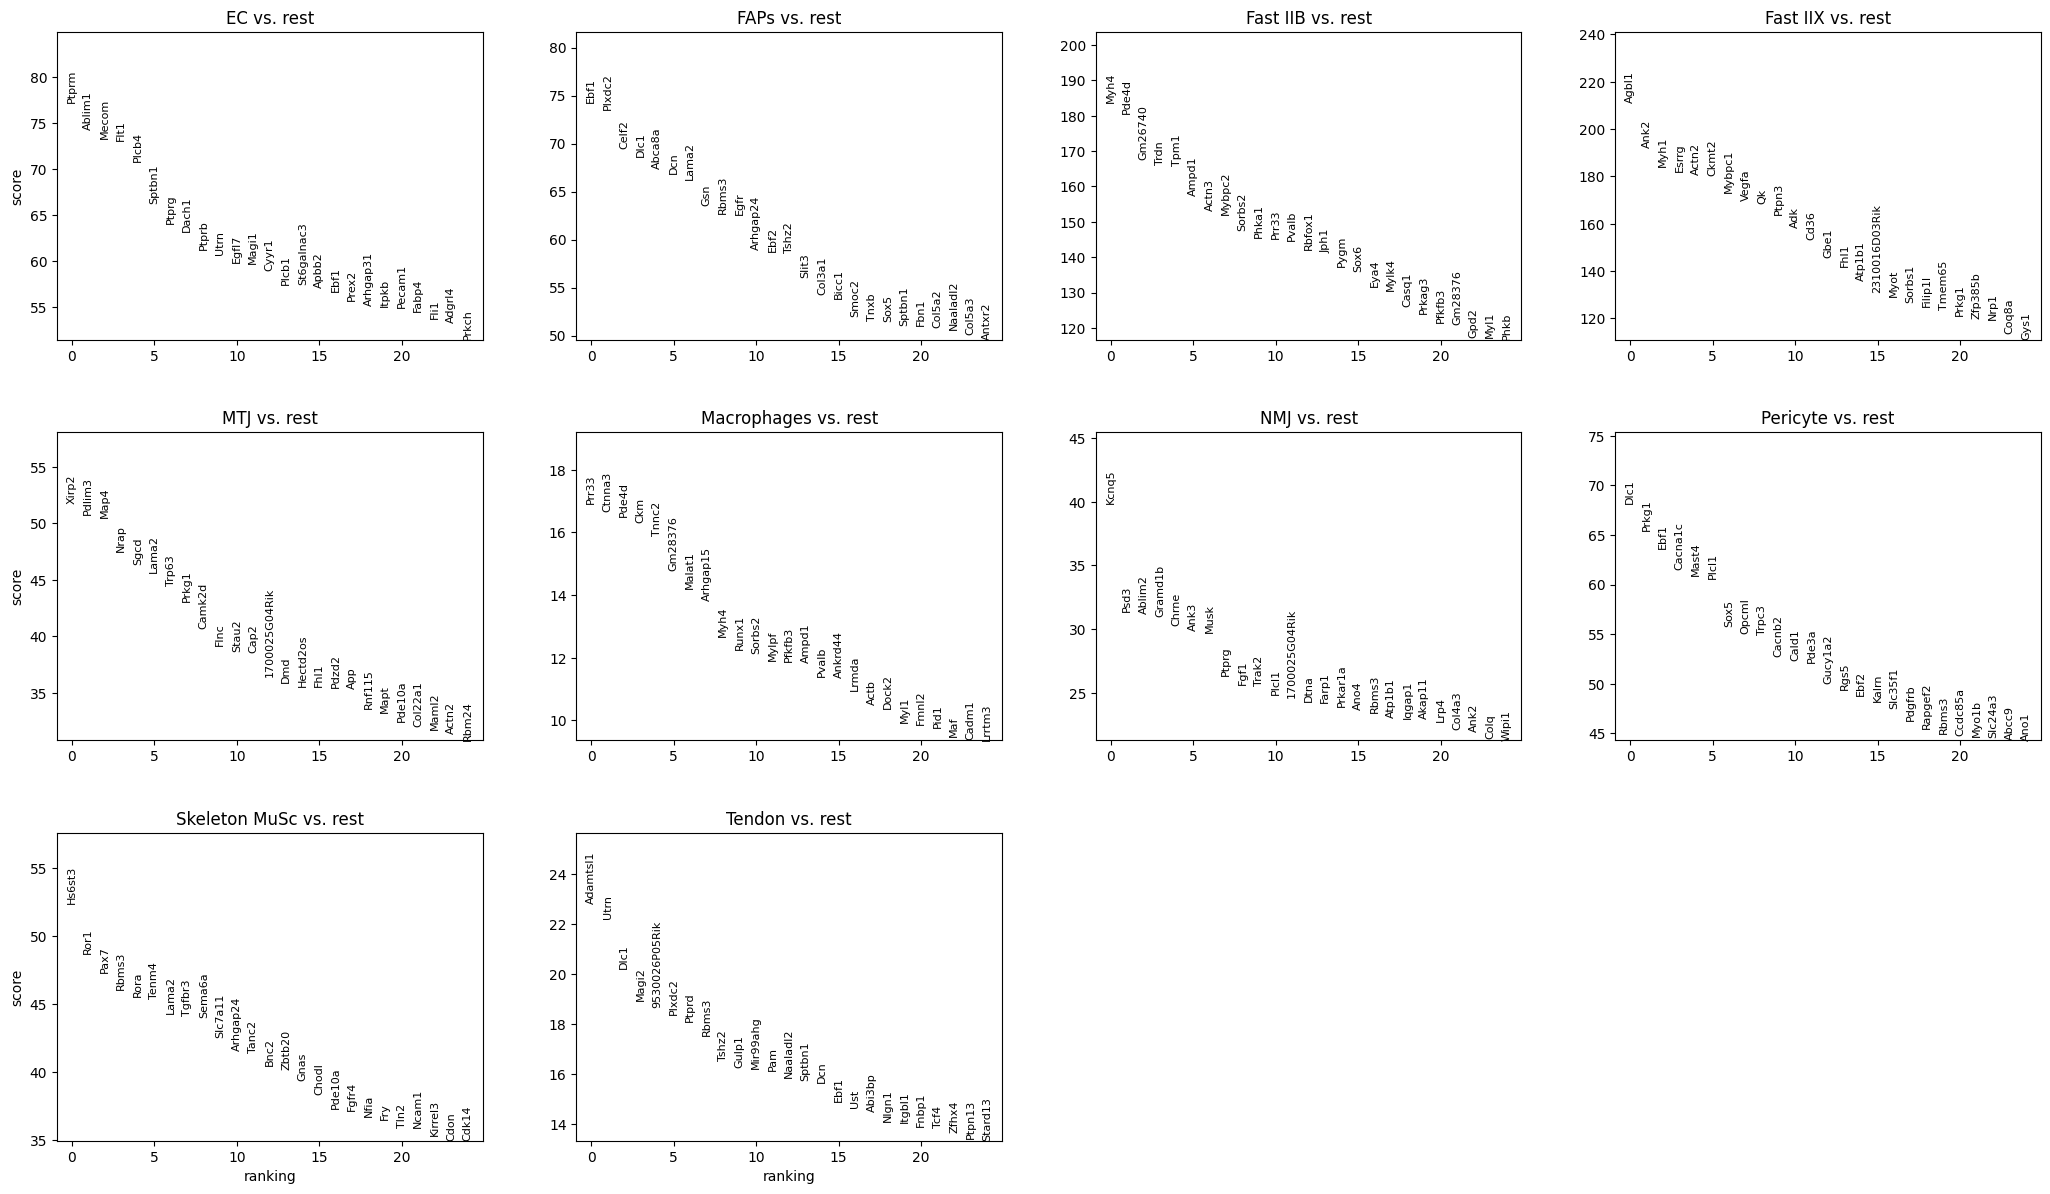

In [ ]:
# marker genes per cell type
sc.tl.rank_genes_groups(adata, groupby="C_scANVI", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
